In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sb
import warnings
warnings.filterwarnings('ignore')

In [2]:
train_dataset = pd.read_csv("/kaggle/input/playground-series-s4e8/train.csv")
test_dataset = pd.read_csv("/kaggle/input/playground-series-s4e8/test.csv")

In [3]:
pd.options.display.float_format = '{:.3f}'.format # Set display option for 3 decimal places

# Data Pre-processing
## Dropping Duplicates

In [4]:
#Dropping duplicates
# duplicated_rows = train_dataset[train_dataset.duplicated(keep=False)]
# print(f"Duplicated values (before dropping): {duplicated_rows.sum()}")
train_dataset.drop_duplicates(inplace=True)
# print(f"Duplicated values (after dropping): {train_dataset.duplicated().sum()}")

## Visualizing missing values

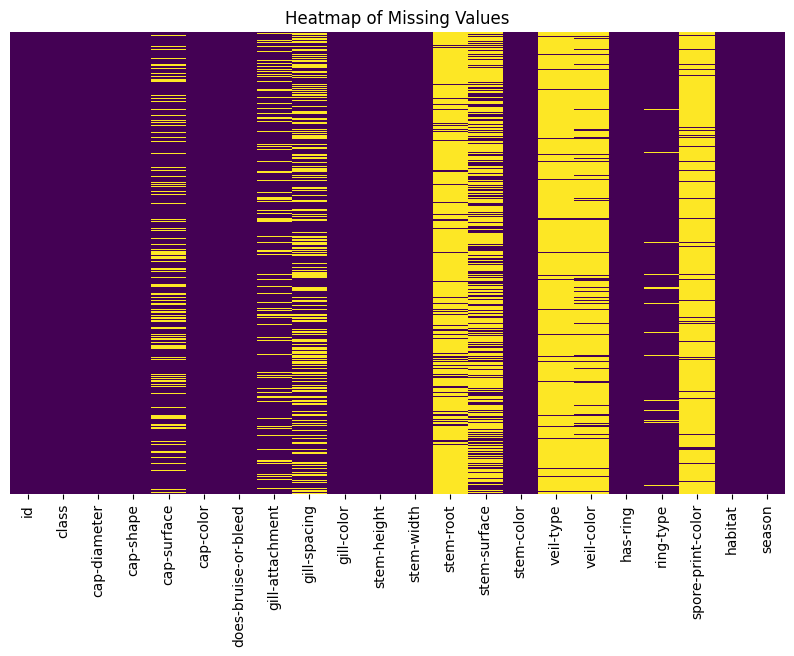

In [5]:
# Create a heatmap to visualize the null values
plt.figure(figsize=(10, 6))
sb.heatmap(train_dataset.isnull(), cbar=False, cmap='viridis', yticklabels=False)
plt.title('Heatmap of Missing Values')
plt.show()

In [6]:
train_dataset.isnull().sum()

id                            0
class                         0
cap-diameter                  4
cap-shape                    40
cap-surface              671023
cap-color                    12
does-bruise-or-bleed          8
gill-attachment          523936
gill-spacing            1258435
gill-color                   57
stem-height                   0
stem-width                    0
stem-root               2757023
stem-surface            1980861
stem-color                   38
veil-type               2957493
veil-color              2740947
has-ring                     24
ring-type                128880
spore-print-color       2849682
habitat                      45
season                        0
dtype: int64

## Impute missing values

In [7]:
# Impute missing numerical values
train_dataset['cap-diameter'].fillna(train_dataset['cap-diameter'].mean(), inplace=True)  # Fill with mean
# train_dataset['stem-height'].fillna(train_dataset['stem-height'].median(), inplace=True)  # Fill with median
# train_dataset['stem-width'].fillna(0, inplace=True)  # Fill with a specific value

In [8]:
#dropping following columns because of missing values
# train_dataset.drop(['stem-root','stem-surface','veil-type','veil-color', 'spore-print-color'], axis=1,inplace=True)

#Impute missing Categorical columns
train_df_col_names = train_dataset.select_dtypes(include="object").columns
# print(train_df_col_names)
for col_name in train_df_col_names:
    train_dataset[col_name].fillna('na', inplace=True)

In [9]:
#Cardinality of categorical columns
for col_name in train_df_col_names:
#     train_dataset[col_name].fillna("na", inplace=True)
    print(f"{col_name} : {len(train_dataset[col_name].unique())}")

class : 2
cap-shape : 75
cap-surface : 84
cap-color : 79
does-bruise-or-bleed : 27
gill-attachment : 79
gill-spacing : 49
gill-color : 64
stem-root : 39
stem-surface : 61
stem-color : 60
veil-type : 23
veil-color : 25
has-ring : 24
ring-type : 41
spore-print-color : 33
habitat : 53
season : 4


## Test & train slpit

In [10]:
X = train_dataset.drop(['id', 'class'], axis=1)
y = train_dataset['class']

In [11]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=1)

## Encoding target variable (Label Encode)

In [12]:
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
y_train = label_encoder.fit_transform(y_train)
y_test = label_encoder.transform(y_test)

## Encoding features (Target Encoding)

In [13]:
import category_encoders as ce
target_encoder = ce.TargetEncoder(cols= train_df_col_names.drop('class'))
X_train = target_encoder.fit_transform(X_train, y_train)
X_test = target_encoder.transform(X_test)

## Correlation between features

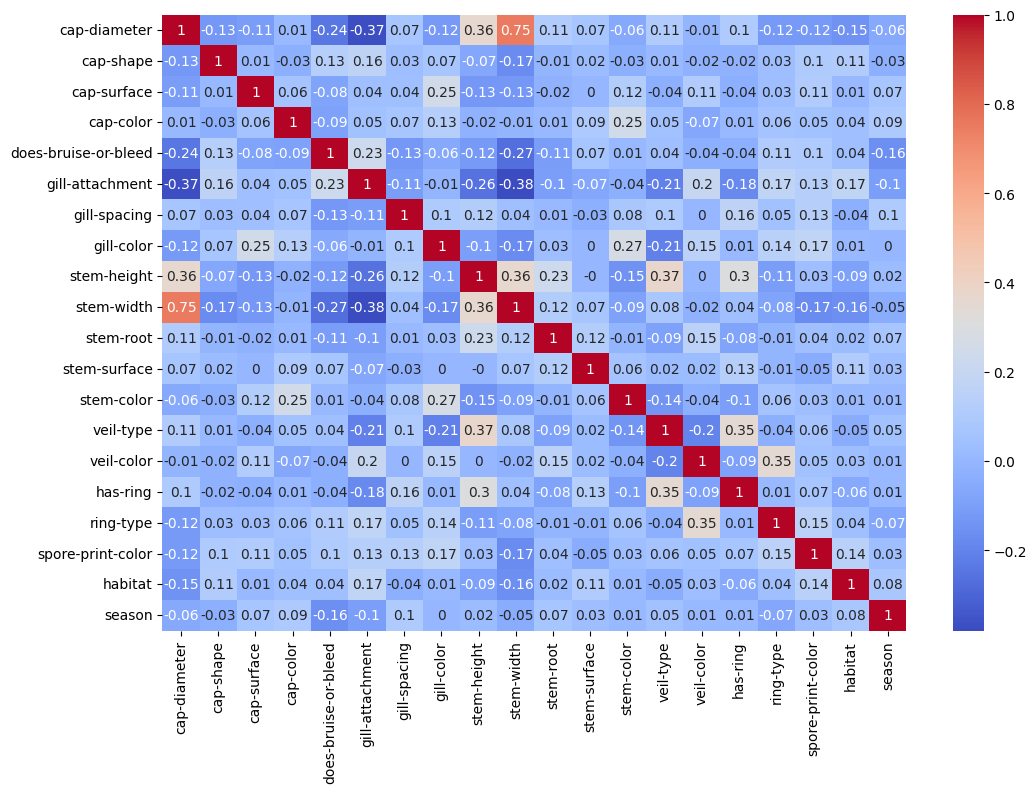

In [14]:
correlation_matrix = X_train.corr().round(2)

plt.figure(figsize=(12, 8))
sb.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.show()
# stem-width and cap-diameter are highly correlated 

## Feature Scaling

In [15]:
#Feature scaling is not necessary for a random forest classifier. But it slighly increase the accuracy
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer

numerical_cols = ['cap-diameter','stem-height', 'stem-width']
ct = ColumnTransformer(transformers=[('feature_scaler', StandardScaler(), numerical_cols)] , remainder='passthrough' )

X_train = ct.fit_transform(X_train)
X_test = ct.transform(X_test)

In [16]:
X_train.shape

(2805250, 20)

In [25]:
y_train.shape

(2805250,)

In [26]:
y_train = y_train.reshape(-1, 1)

In [27]:
y_train.shape

(2805250, 1)

In [30]:
y_test = y_test.reshape(-1, 1)

# Model development

In [18]:
import tensorflow as tf
from tensorflow.keras import backend as K
print(tf.__version__)

2.15.0


In [34]:
from tensorflow.keras.callbacks import ModelCheckpoint

# Define the checkpoint directory and file name
checkpoint_filepath = 'checkpoints/model.keras'

# Create the ModelCheckpoint callback
checkpoint_callback = ModelCheckpoint(
    filepath=checkpoint_filepath,  # Path to save the model file
    monitor='val_loss',             # Metric to monitor for saving
    save_best_only=True,            # Only save the model if the monitored metric improves
    save_weights_only=False,        # Save the entire model (set to True to save only weights)
    mode='min',                     # Mode for monitoring (min, max, or auto)
    verbose=1                       # Verbosity mode
)


In [42]:
class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    '''
    Halts the training when the accuracy > 0.9843

    Args:
      epoch (integer) - index of epoch (required but unused in the function definition below)
      logs (dict) - metric results from the training epoch
    '''

    # Check the loss
    if(logs.get('accuracy') > 0.999):

      # Stop if threshold is met
      print("\nAccuracy is higher than 0.9843 so cancelling training!")
      self.model.stop_training = True

# Instantiate class
accuracy_callback = myCallback()

In [39]:
# def matthews_correlation_coefficient(y_true, y_pred):
#     y_pred_pos = K.cast(K.round(K.clip(y_pred, 0, 1)), dtype='float32')
#     y_pred_neg = 1 - y_pred_pos

#     y_pos = K.cast(K.round(K.clip(y_true, 0, 1)), dtype='float32')
#     y_neg = 1 - y_pos

#     tp = K.sum(y_pos * y_pred_pos)
#     tn = K.sum(y_neg * y_pred_neg)

#     fp = K.sum(y_neg * y_pred_pos)
#     fn = K.sum(y_pos * y_pred_neg)

#     numerator = (tp * tn) - (fp * fn)
#     denominator = K.sqrt((tp + fp) * (tp + fn) * (tn + fp) * (tn + fn))

#     return numerator / (denominator + K.epsilon())
import tensorflow as tf
from sklearn.metrics import matthews_corrcoef

def matthews_correlation_coefficient(y_true, y_pred):
    # Convert predictions to binary using a threshold of 0.5
    y_pred_bin = tf.cast(tf.greater_equal(y_pred, 0.5), tf.int32)
    
    # Define a function to compute the MCC using sklearn
    def sklearn_mcc(y_true, y_pred_bin):
        return matthews_corrcoef(y_true, y_pred_bin)
    
    # Use tf.py_function to wrap the sklearn MCC function
    result = tf.py_function(sklearn_mcc, (y_true, y_pred_bin), tf.double)
    
    return result

In [43]:
from tensorflow.keras.metrics import BinaryAccuracy
model = tf.keras.Sequential([
    tf.keras.layers.InputLayer(input_shape=(20,)),  # Input shape should match your dataset
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(1, activation='sigmoid')  # Sigmoid for binary classification
])

model.compile(optimizer=tf.keras.optimizers.Adam(),
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=['accuracy']
             )

model.summary()

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_25 (Dense)                │ (None, 32)             │           672 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_26 (Dense)                │ (None, 64)             │         2,112 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_27 (Dense)                │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_28 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_29 (Dense)                │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 9,057 (35.38 KB)

 Trainable params: 9,057 (35.38 KB)

 Non-trainable params: 0 (0.00 B)

In [44]:
history = model.fit(x=X_train, y=y_train, epochs=20, shuffle=True, callbacks=[accuracy_callback, checkpoint_callback])

Epoch 1/20
87665/87665 ━━━━━━━━━━━━━━━━━━━━ 144s 2ms/step - accuracy: 0.9344 - loss: 0.1780
Epoch 2/20
87665/87665 ━━━━━━━━━━━━━━━━━━━━ 139s 2ms/step - accuracy: 0.9808 - loss: 0.0768
Epoch 3/20
87665/87665 ━━━━━━━━━━━━━━━━━━━━ 142s 2ms/step - accuracy: 0.9834 - loss: 0.0696
Epoch 4/20
87665/87665 ━━━━━━━━━━━━━━━━━━━━ 139s 2ms/step - accuracy: 0.9846 - loss: 0.0666
Epoch 5/20
87665/87665 ━━━━━━━━━━━━━━━━━━━━ 138s 2ms/step - accuracy: 0.9852 - loss: 0.0643
Epoch 6/20
87665/87665 ━━━━━━━━━━━━━━━━━━━━ 139s 2ms/step - accuracy: 0.9858 - loss: 0.0630
Epoch 7/20
87665/87665 ━━━━━━━━━━━━━━━━━━━━ 138s 2ms/step - accuracy: 0.9860 - loss: 0.0625
Epoch 8/20
87665/87665 ━━━━━━━━━━━━━━━━━━━━ 139s 2ms/step - accuracy: 0.9866 - loss: 0.0613
Epoch 9/20
87665/87665 ━━━━━━━━━━━━━━━━━━━━ 137s 2ms/step - accuracy: 0.9865 - loss: 0.0614
Epoch 10/20
87665/87665 ━━━━━━━━━━━━━━━━━━━━ 138s 2ms/step - accuracy: 0.9868 - loss: 0.0608
Epoch 11/20
87665/87665 ━━━━━━━━━━━━━━━━━━━━ 137s 2ms/step - accuracy: 0.9869 -

In [45]:
history.history

{'accuracy': [0.9640263915061951,
  0.9816398024559021,
  0.9836581349372864,
  0.9847478866577148,
  0.9853663444519043,
  0.9858914613723755,
  0.9861413240432739,
  0.9864814281463623,
  0.9865858554840088,
  0.9867990612983704,
  0.9868553876876831,
  0.9870671033859253,
  0.987066388130188,
  0.9870667457580566,
  0.9871298670768738,
  0.9872321486473083,
  0.9872321486473083,
  0.9872321486473083,
  0.9872278571128845,
  0.9871886372566223],
 'loss': [0.11747504770755768,
  0.07451692968606949,
  0.06883750110864639,
  0.06598524004220963,
  0.0639776661992073,
  0.0626450702548027,
  0.062241505831480026,
  0.06167076900601387,
  0.06131522357463837,
  0.0609874352812767,
  0.06049330532550812,
  0.06034023314714432,
  0.06022769957780838,
  0.059973035007715225,
  0.06032572686672211,
  0.060229312628507614,
  0.0600302554666996,
  0.06020846590399742,
  0.060581982135772705,
  0.06067609414458275]}

In [46]:
# Get the probability predictions
y_prob = model.predict(X_test)

# Convert probabilities to binary outputs (1 or 0) using a threshold of 0.5
y_pred = (y_prob > 0.5).astype(int)

9741/9741 ━━━━━━━━━━━━━━━━━━━━ 12s 1ms/step


In [ ]:
y_pred[0:10]

In [47]:
from sklearn.metrics import confusion_matrix
conf_matrix = confusion_matrix(y_test, y_pred, normalize='true')
print(conf_matrix)

[[0.98840917 0.01159083]
 [0.01441244 0.98558756]]


In [48]:
from sklearn.metrics import matthews_corrcoef
matthews_corrcoef(y_test, y_pred)

0.9735049503161305